# California Housing Prices Analysis
Kevin Nolasco

Cabrini University

MCIS560 - Introduction to Machine Learning

1/23/2022

## Introduction
According to [CNBC](https://www.cnbc.com/2021/11/10/home-prices-are-now-rising-much-faster-than-incomes-studies-show.html), the prices of houses has skyrocketed during the pandemic. This issue is affecting home buyers throughout the United States. To make the home buying process easier it is important to provide home buyers accurate housing prices. In an attempt to create an accurate pricing model, we will look at California housing prices and the different features of the home to see how they affect the price.

### Approach


## Code
## Import Data

In [44]:
# import packages
import os
import tarfile
import urllib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# assign paths
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

# function to make directory for the housing data
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

# function to load the data using pandas
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
# load data
fetch_housing_data()

housing_df = load_housing_data()

## Exploratory Data Analysis
What are the datatypes? How many records are there? Any Nulls?

In [4]:
# dtypes?
housing_df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

Above we can see that ocean_proximity is an "object" datatype. This is pandas' way of representing a string. This means that this feature is categorical and we will need to one-hot encode it if we wish to use it in our model.

In [5]:
# record count?
n_rows, n_cols = housing_df.shape
print('This dataset contains {} rows and {} columns.'.format(n_rows, n_cols))

This dataset contains 20640 rows and 10 columns.


In [6]:
# any missing values?
housing_df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Looks like we have 207 missing records for total_bedrooms. Since that is a small fraction of the total record count we will remove those rows instead of removing the feature entirely.

In [7]:
# drop missing values
housing_df.dropna(axis = 0, inplace = True)

### Ocean Proximity Impact

I believe one of the reasons that California is a high value state is because of the beach. In this next section we will look at how the Ocean Proximity is affecting the housing prices.

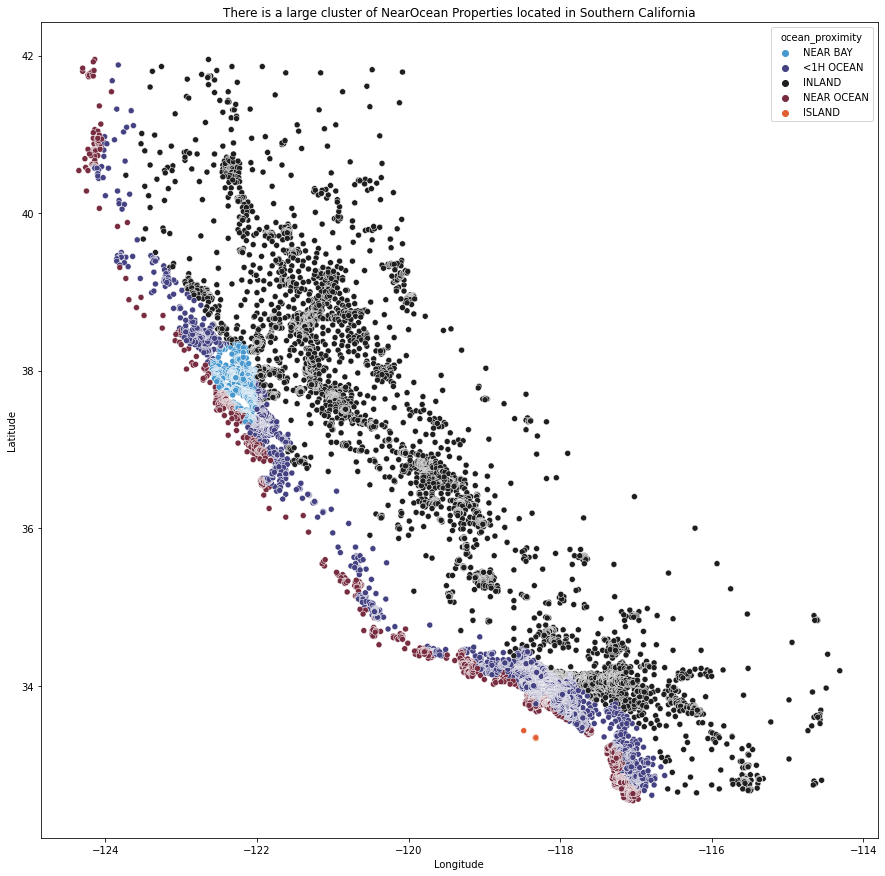

In [8]:
# visualize

fig, axs = plt.subplots(1,1)
fig.set_size_inches(15,15)

g = sns.scatterplot(data = housing_df, x = 'longitude', y = 'latitude', 
                    hue = 'ocean_proximity', palette = 'icefire')

g.set(xlabel = 'Longitude', ylabel = 'Latitude', title = 'There is a large cluster of NearOcean Properties located in Southern California')
plt.show()

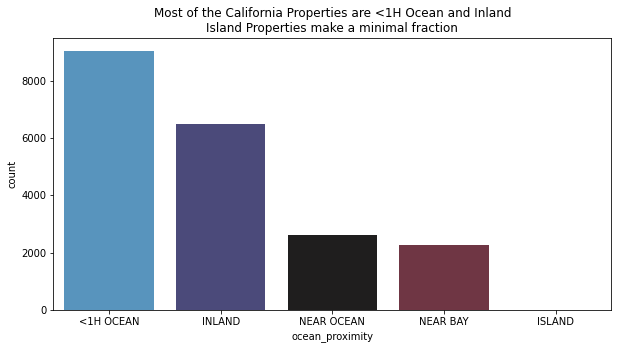

In [15]:
# distribution of ocean proximity

fig, axs = plt.subplots(1,1)
fig.set_size_inches(10,5)

g = sns.countplot(data = housing_df, x = 'ocean_proximity',
                    order = housing_df['ocean_proximity'].value_counts().index,
                    palette = 'icefire')

g.set(title = 'Most of the California Properties are <1H Ocean and Inland\nIsland Properties make a minimal fraction')
plt.show()

Above we can see that Island properties are very few, so we will drop them to keep it from skewing our data.

In [18]:
# drop island
housing_df = housing_df[housing_df['ocean_proximity'] != 'ISLAND']
# check to see it dropped
housing_df['ocean_proximity'].value_counts()

<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
Name: ocean_proximity, dtype: int64

### Cost By Ocean Proximity

Let's see the median property value by ocean proximity.

In [22]:
# cost by ocean proximity
ocean_costs = housing_df.groupby(['ocean_proximity'])['median_house_value'].median().round(0)
ocean_costs

ocean_proximity
<1H OCEAN     215000.0
INLAND        108700.0
NEAR BAY      233800.0
NEAR OCEAN    228750.0
Name: median_house_value, dtype: float64

#### Northern/Southern California 

I believe there is probably a difference in pricing between Northern and Southern California. Based on the map above, we can define the cut-off for North and South at 36 Latitude. We will write a function to create a new categorical feature and see if we can find a difference in median prices for Northern and Southern California.

In [23]:
def seperate_north_south(latitude):
    if latitude > 36:
        return 'northern'
    else:
        return 'southern'

In [24]:
# apply function
housing_df['latitude_region'] = housing_df['latitude'].apply(seperate_north_south)

In [25]:
# see distribution
housing_df['latitude_region'].value_counts()

southern    11690
northern     8738
Name: latitude_region, dtype: int64

In [27]:
# group by region and ocean proximity
ocean_region_costs = housing_df.groupby(['latitude_region','ocean_proximity'])['median_house_value'].median()
ocean_region_costs

latitude_region  ocean_proximity
northern         <1H OCEAN          240000.0
                 INLAND             104000.0
                 NEAR BAY           233800.0
                 NEAR OCEAN         276800.0
southern         <1H OCEAN          209400.0
                 INLAND             115300.0
                 NEAR OCEAN         196200.0
Name: median_house_value, dtype: float64

Now that we divided California into Northern and Southern parts we could see the difference in median values for Near Ocean costs. 

We can see that:
- **North California Near Ocean** costs are about \$80,000 more expensive than **Southern California Near Ocean** properties.
- **Northern California <1H Ocean** costs are about \$30,000 more expensive than **Southern California <1H Ocean** properties.

## Population And Median Income Against Median Household Value

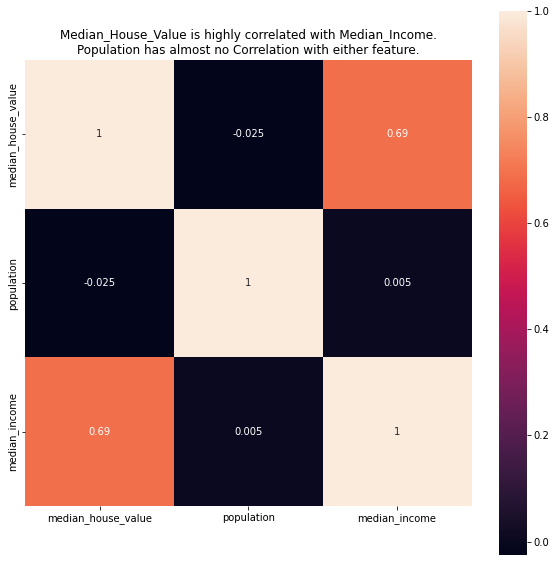

In [34]:
corr = housing_df[['median_house_value', 'population','median_income']].corr()

fig, axs = plt.subplots(1,1)
fig.set_size_inches(10,10)

g = sns.heatmap(corr, square = True, annot  = True)

g.set(title = 'Median_House_Value is highly correlated with Median_Income.\nPopulation has almost no Correlation with either feature.')
plt.show()

In [35]:
# drop population since it is not correlated to the target
housing_df.drop(['population'], axis = 1, inplace = True)

## Latitude and Longitude against Median_House_Value

I suspect that Longitude coordinates are not as correlated with the final median house value as Latitude is because of how "slanted" California is. We will test this hypothesis by analyzing a heatmap.

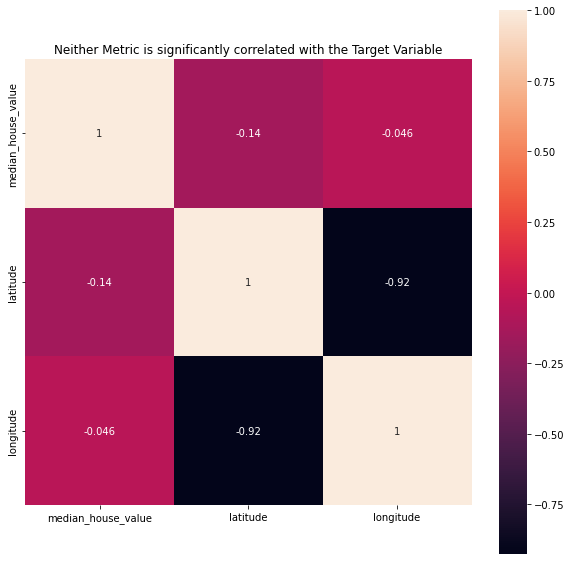

In [38]:
corr = housing_df[['median_house_value', 'latitude','longitude']].corr()

fig, axs = plt.subplots(1,1)
fig.set_size_inches(10,10)

g = sns.heatmap(corr, square = True, annot  = True)

g.set(title = 'Neither Metric is significantly correlated with the Target Variable')
plt.show()

In [39]:
# drop longitude and latitude from df
housing_df.drop(['latitude','longitude'], axis = 1, inplace = True)

# Prep Data for ML Model

Since I plan on using a Random Forest Regressor model, there is no need to scale the features. There is still a need to encode the categorical variables, isolate the target variable, and make a training and testing set. This will be done below.

# Model Using Random Forest Regressor

In [43]:
rf = RandomForestRegressor(random_state = 42)